In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from acv_explainers import ACXplainer
from acv_explainers.utils import *
from sklearn.metrics import roc_auc_score, accuracy_score

In [2]:
seed = 2022
X = pd.read_csv('data/lucas0_train.csv')
y = X['Lung_cancer'].values
X.drop(['Lung_cancer'], axis=1, inplace=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.20, random_state=seed)

### Train Explainer (ACXplainer)

In [4]:
acv_xplainer = ACXplainer(classifier=True, n_estimators=20, max_depth=10)
acv_xplainer.fit(X_train, y_train)

print('# Trained ACXplainer -- score = {}'.format(accuracy_score(y_test, acv_xplainer.predict(X_test))))

# idx = 0
# size = idx + 500
x, y = X_test[:500], y_test[:500]
x_rules, y_rules = X_train[:1000], y_train[:1000]

# Trained ACXplainer -- score = 0.83


In [1]:
# sdp_importance, min_sufficient_expl, size, sdp = acv_xplainer.importance_sdp_rf(x, y, X_train, y_train, pi_level=0.9)

### Compute the Sufficient Explanations and LXI

In [47]:
sufficient_expl, sdp_expl, sdp_global = acv_xplainer.sufficient_expl_rf(x, y, X_train, y_train, pi_level=0.8)

100%|███████████████████████████████████████████| 10/10 [10:48<00:00, 64.87s/it]


In [48]:
def compute_lximp(sufficient_expl, d):
    local_sdp = np.zeros(shape=(len(sufficient_expl), d))
    for idx in range(len(sufficient_expl)):
        sufficient_coal = sufficient_expl[idx][1:]    
        flat = [item for sublist in sufficient_coal for item in sublist]
        flat = pd.Series(flat)
        flat = dict(flat.value_counts() / len(sufficient_coal))
        for key in flat.keys():
            local_sdp[idx, key] = flat[key]
    return local_sdp

In [49]:
lximp = compute_lximp(sufficient_expl, X_train.shape[1])

In [50]:
def bar_legacy(shap_values, features=None, feature_names=None, max_display=None, show=True):
    # unwrap pandas series

    fig = plt.figure()

    if str(type(features)) == "<class 'pandas.core.series.Series'>":
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(len(shap_values))])

    if max_display is None:
        max_display = 7
    else:
        max_display = min(len(feature_names), max_display)

    feature_order = np.argsort(-np.abs(shap_values))

    #
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)
    plt.barh(
        y_pos, shap_values[feature_inds],
        0.7, align='center',
        color=[colors.red_rgb if shap_values[feature_inds[i]] < 0 else colors.blue_rgb for i in range(len(y_pos))]
    )
    for y in range(len(y_pos)):
        plt.text(shap_values[feature_inds][y] + 0.001, y_pos[y] - 0.07, round(shap_values[feature_inds][y], 3))

    plt.yticks(y_pos, fontsize=13)
    if features is not None:
        features = list(features)

        # try and round off any trailing zeros after the decimal point in the feature values
        for i in range(len(features)):
            try:
                if round(features[i]) == features[i]:
                    features[i] = int(features[i])
            except TypeError:
                pass  # features[i] must not be a number
    yticklabels = []
    for i in feature_inds:
        if features is not None:
            yticklabels.append(feature_names[i] + " = " + str(features[i]))
        else:
            yticklabels.append(feature_names[i])
    plt.gca().set_yticklabels(yticklabels)
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('none')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['left'].set_visible(False)

    plt.xlabel("Frequency of apparition in the Sufficient Coalitions")
    return fig

In [51]:
columns_name = [col for col in X.columns]

In [52]:
from acv_app.colors import _colors as colors

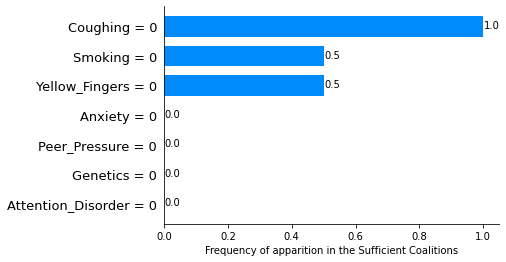

In [54]:
fig = bar_legacy(lximp[0], features=x[0], feature_names=columns_name) #LXI importance

In [55]:
from shap import TreeExplainer
from skranger.ensemble import RangerForestClassifier
from skranger.utils.shap import shap_patch

with shap_patch():
    explainer = TreeExplainer(model=acv_xplainer.model)

In [56]:
shap_values = explainer.shap_values(x)[1]

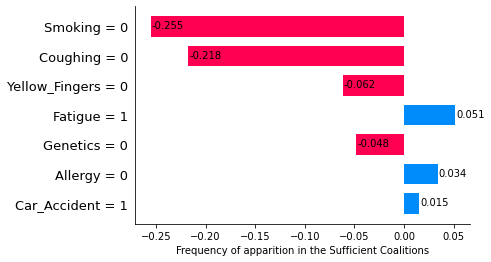

In [57]:
fig_shap = bar_legacy(shap_values[0], features=x[0], feature_names=columns_name) # SHAP values importance

# Plot mean attributions

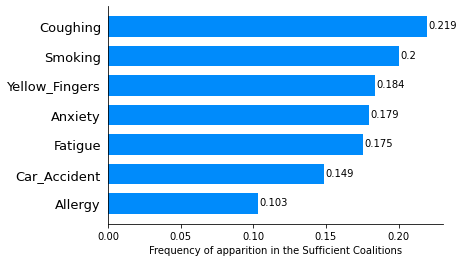

In [59]:
fig = bar_legacy(np.mean(lximp, axis=0), feature_names=columns_name) # LXI mean

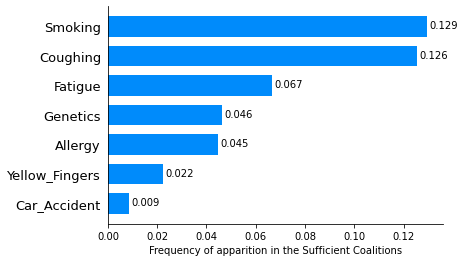

In [60]:
fig = bar_legacy(np.mean(np.abs(shap_values), axis=0), feature_names=columns_name) # Mean absolute SHAP values

## Run WebAPP

In [ ]:
import acv_app
import os

seed = 2022
X_plot = pd.read_csv('lucas0_train.csv')
y_plot = X_plot['Lung_cancer'].values
X_plot.drop(['Lung_cancer'], axis=1, inplace=True)


# compile the ACXplainer
acv_app.compile_ACXplainers(acv_xplainer, X_plot, y_plot, X_plot, y_plot, path=os.getcwd())

# Launch the webApp
acv_app.run_webapp(pickle_path=os.getcwd())


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.76:8501



100%|██████████| 10/10 [01:25<00:00,  8.56s/it]
